In [1]:
!pip install -q xgboost shap optuna
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, RocCurveDisplay)
import xgboost as xgb, shap, optuna, warnings, joblib
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='Set2')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.9 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/content/dataset.csv')
print('Shape:', df.shape)
df.head()

Shape: (1190, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


Duplicates: 272


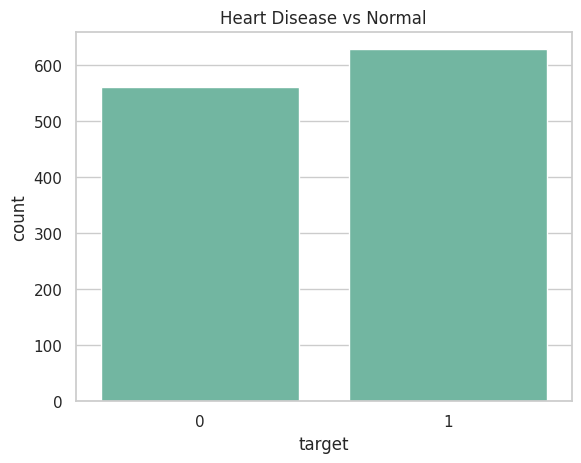

In [4]:
display(df.isna().sum().sort_values(ascending=False).head(10))
print('Duplicates:', df.duplicated().sum())
sns.countplot(x='target', data=df)
plt.title('Heart Disease vs Normal');


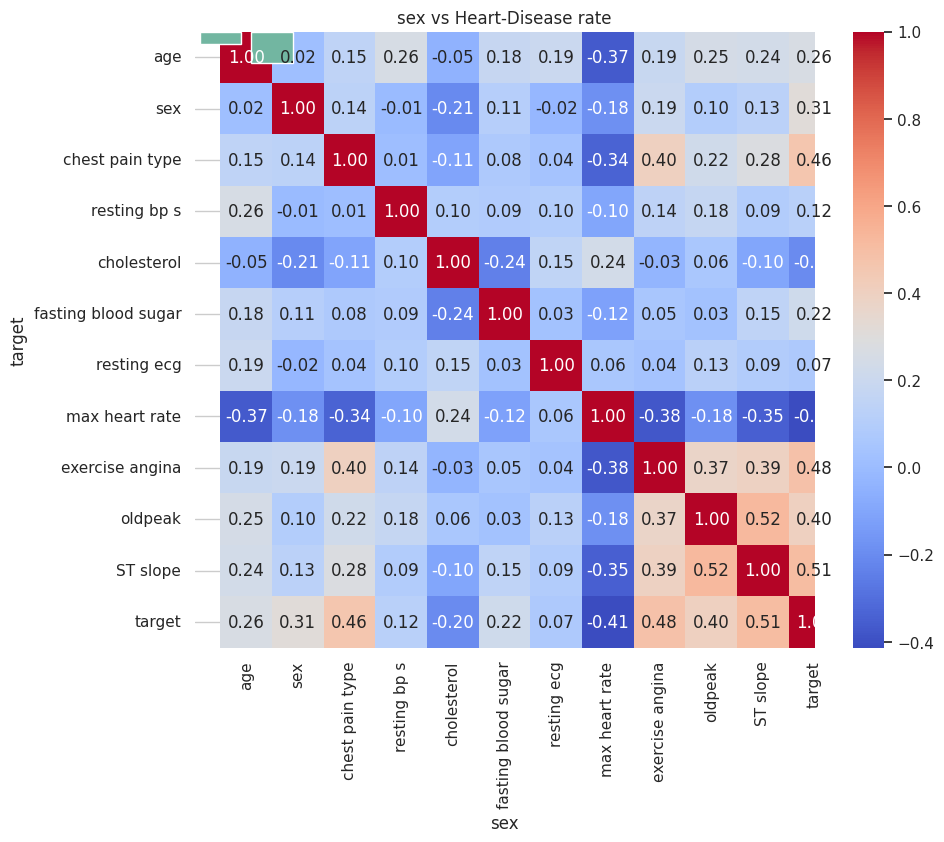

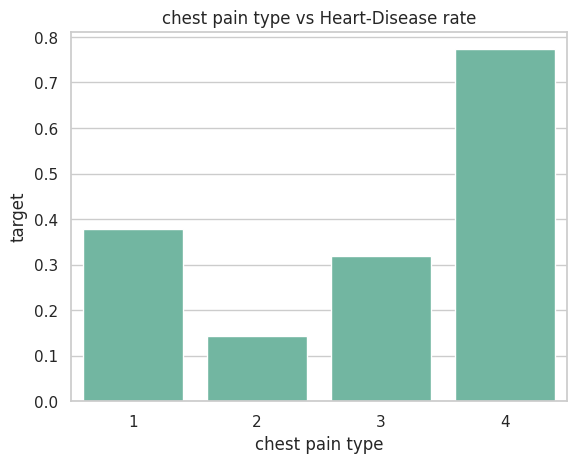

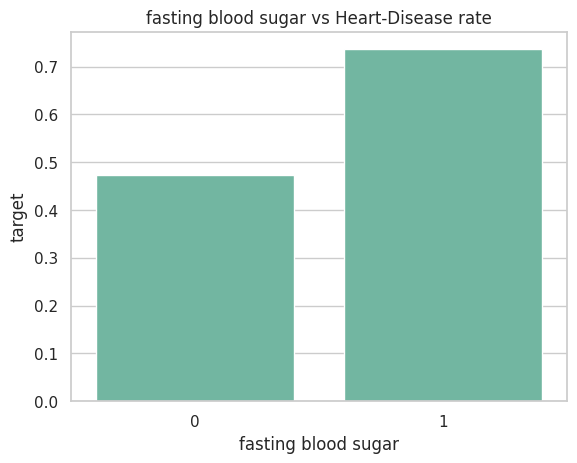

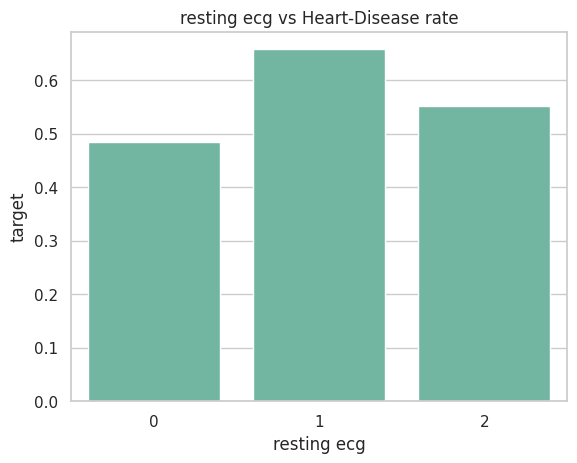

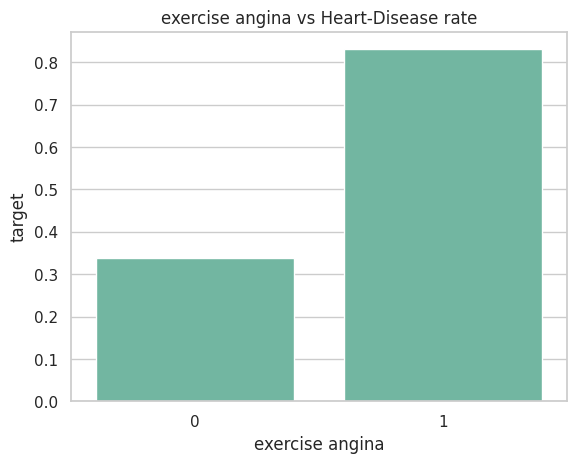

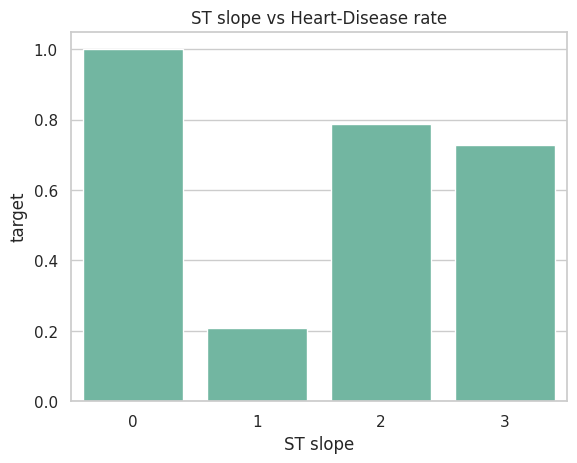

In [5]:
# ╔═ 4.1 Numeric overview
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].describe().T

# ╔═ 4.2 Correlation heat-map
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Pearson correlation');

# ╔═ 4.3 Categorical vs Target
cat_cols = ['sex','chest pain type','fasting blood sugar',
            'resting ecg','exercise angina','ST slope']
for c in cat_cols:
    sns.barplot(x=c, y='target', data=df, ci=None)
    plt.title(f'{c} vs Heart-Disease rate')
    plt.show()

In [6]:
X = df.drop('target', axis=1)
y = df['target']

# Identify column types
numeric = ['age','resting bp s','cholesterol','max heart rate','oldpeak']
categorical = ['sex','chest pain type','fasting blood sugar',
               'resting ecg','exercise angina','ST slope']

pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[('prep', pre),
                        ('clf', LogisticRegression(max_iter=1000))])
log_reg.fit(X_train, y_train)

pred_lr = log_reg.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

Accuracy: 0.8613445378151261
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       112
           1       0.85      0.89      0.87       126

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.86      0.86      0.86       238



In [8]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = Pipeline(steps=[
        ('prep', pre),
        ('clf', xgb.XGBClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, prob))

    return np.mean(aucs)

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-09-23 06:45:45,367] A new study created in memory with name: no-name-1f5236b7-2af3-4419-bbd7-220ab777e0a5


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-23 06:45:46,222] Trial 0 finished with value: 0.9246374432948914 and parameters: {'n_estimators': 730, 'max_depth': 3, 'learning_rate': 0.022260857915323264, 'subsample': 0.7637003830055044, 'colsample_bytree': 0.7157666978926237, 'gamma': 4.837808553316001, 'min_child_weight': 6}. Best is trial 0 with value: 0.9246374432948914.
[I 2025-09-23 06:45:46,966] Trial 1 finished with value: 0.923288053299712 and parameters: {'n_estimators': 616, 'max_depth': 4, 'learning_rate': 0.012384551342272064, 'subsample': 0.7596718923561849, 'colsample_bytree': 0.7611520497549638, 'gamma': 4.61394165013244, 'min_child_weight': 6}. Best is trial 0 with value: 0.9246374432948914.
[I 2025-09-23 06:45:47,745] Trial 2 finished with value: 0.9493881534220838 and parameters: {'n_estimators': 258, 'max_depth': 8, 'learning_rate': 0.041465113365742, 'subsample': 0.7193007189874031, 'colsample_bytree': 0.974385166198842, 'gamma': 0.022230262794938893, 'min_child_weight': 2}. Best is trial 2 with valu

In [10]:
# ------------------------------------------------------------------
# Re-build the best model found by Optuna
# ------------------------------------------------------------------
best_xgb = Pipeline(steps=[
    ('prep', pre),
    ('clf', xgb.XGBClassifier(**study.best_params, random_state=42))
])
best_xgb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'resting bp s',
                                                   'cholesterol',
                                                   'max heart rate',
                                                   'oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'chest pain type',
                                                   'fasting blood sugar',
                                                   'resting ecg',
                                                   'exercise angina',
                                                   'ST slope'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_...
                               gamma=0.3070702098185155, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08577714317790092, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=353, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [11]:
pred = best_xgb.predict(X_test)
prob = best_xgb.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, prob))

Accuracy: 0.9327731092436975
F1: 0.9365079365079365
ROC-AUC: 0.9670493197278912


Accuracy: 0.9327731092436975
F1: 0.9365079365079365
ROC-AUC: 0.9670493197278912
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       112
           1       0.94      0.94      0.94       126

    accuracy                           0.93       238
   macro avg       0.93      0.93      0.93       238
weighted avg       0.93      0.93      0.93       238



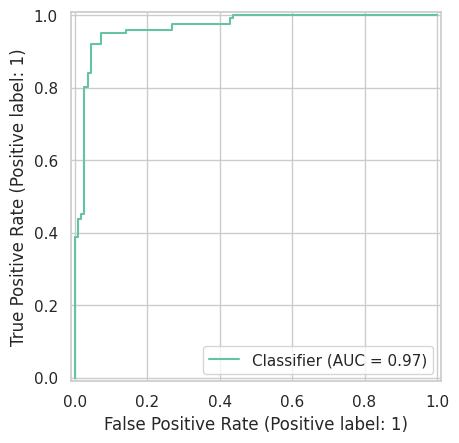

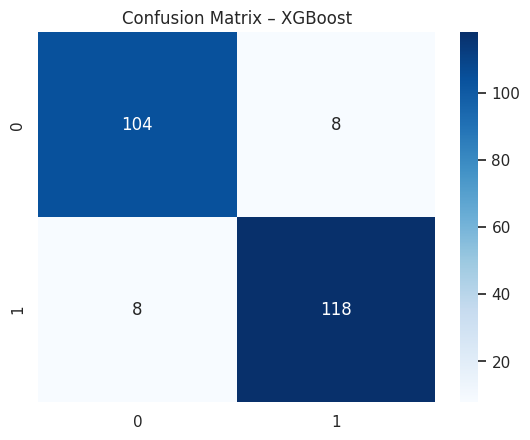

In [12]:
pred = best_xgb.predict(X_test)
prob = best_xgb.predict_proba(X_test)[:,1]

print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, prob))
print(classification_report(y_test, pred))

RocCurveDisplay.from_predictions(y_test, prob)
plt.show();

sns.heatmap(confusion_matrix(y_test, pred),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – XGBoost');

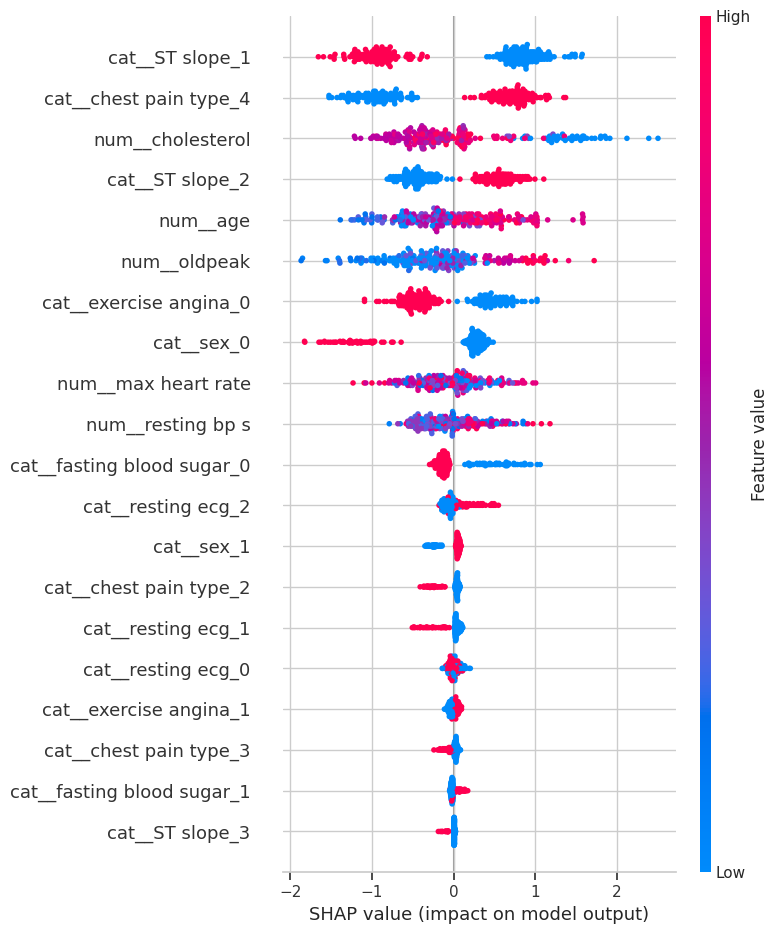

In [13]:
explainer = shap.Explainer(best_xgb.named_steps['clf'],
                         best_xgb.named_steps['prep'].transform(X_train))
shap_values = explainer(best_xgb.named_steps['prep'].transform(X_test))

shap.summary_plot(shap_values, features=best_xgb.named_steps['prep'].transform(X_test),
                  feature_names=best_xgb.named_steps['prep'].get_feature_names_out())

In [14]:
joblib.dump(best_xgb, 'heart_disease_xgb.pkl')
print('Model saved to heart_disease_xgb.pkl')

Model saved to heart_disease_xgb.pkl


In [15]:
#!/usr/bin/env python3
"""
Interactive CLI for heart-disease prediction
Matches the PDF attribute order & coding exactly.
"""
import joblib, os, pandas as pd, numpy as np

MODEL = "heart_disease_xgb.pkl"
if not os.path.exists(MODEL):
    raise FileNotFoundError(f"{MODEL} not found – train & save the model first.")

pipe = joblib.load(MODEL)

# PDF order & prompts ---------------------------------------------------------
PROMPTS = {
    "age":                "Enter your age (years): ",
    "sex":                "Enter sex 0=female 1=male: ",
    "chest pain type":    "Chest-pain type (1=typical 2=atypical 3=non-anginal 4=asymptomatic): ",
    "resting bp s":       "Resting BP (mm Hg): ",
    "cholesterol":        "Serum cholesterol (mg/dl): ",
    "fasting blood sugar":"Fasting blood sugar >120 mg/dL? 0=no 1=yes: ",
    "resting ecg":        "Resting ECG (0=normal 1=ST-T abnormality 2=LV hypertrophy): ",
    "max heart rate":     "Max heart rate achieved (71-202): ",
    "exercise angina":    "Exercise-induced angina? 0=no 1=yes: ",
    "oldpeak":            "ST depression (oldpeak): ",
    "ST slope":           "ST slope (1=upsloping 2=flat 3=downsloping): "
}

def ask(prompt, lo, hi, cast=int):
    while True:
        try:
            val = cast(input(prompt))
            if lo <= val <= hi:
                return val
            print(f"  Value must be between {lo} and {hi}")
        except ValueError:
            print("  Invalid number – try again.")

def collect():
    print("\n==== Heart-Disease Predictor ====\n")
    data = {}
    data["age"]                = ask(PROMPTS["age"], 0, 120)
    data["sex"]                = ask(PROMPTS["sex"], 0, 1)
    data["chest pain type"]    = ask(PROMPTS["chest pain type"], 1, 4)
    data["resting bp s"]       = ask(PROMPTS["resting bp s"], 70, 250)
    data["cholesterol"]        = ask(PROMPTS["cholesterol"], 0, 700)
    data["fasting blood sugar"]= ask(PROMPTS["fasting blood sugar"], 0, 1)
    data["resting ecg"]        = ask(PROMPTS["resting ecg"], 0, 2)
    data["max heart rate"]     = ask(PROMPTS["max heart rate"], 71, 202)
    data["exercise angina"]    = ask(PROMPTS["exercise angina"], 0, 1)
    data["oldpeak"]            = ask(PROMPTS["oldpeak"], -5.0, 10.0, float)
    data["ST slope"]           = ask(PROMPTS["ST slope"], 1, 3)
    return data

def main():
    patient = collect()
    X = pd.DataFrame([patient])
    prob = float(pipe.predict_proba(X)[:, 1])
    pred = "Heart Disease" if prob > 0.5 else "Normal"
    print(f"\nResult → {pred}  (probability: {prob:.1%})\n")

if __name__ == "__main__":
    main()


==== Heart-Disease Predictor ====

Enter your age (years): 22
Enter sex 0=female 1=male: 1
Chest-pain type (1=typical 2=atypical 3=non-anginal 4=asymptomatic): 2
Resting BP (mm Hg): 22
  Value must be between 70 and 250
Resting BP (mm Hg): 22
  Value must be between 70 and 250
Resting BP (mm Hg): 3
  Value must be between 70 and 250
Resting BP (mm Hg): 23
  Value must be between 70 and 250
Resting BP (mm Hg): 23
  Value must be between 70 and 250
Resting BP (mm Hg): 23
  Value must be between 70 and 250
Resting BP (mm Hg): 21
  Value must be between 70 and 250
Resting BP (mm Hg): 34
  Value must be between 70 and 250
Resting BP (mm Hg): 32
  Value must be between 70 and 250
Resting BP (mm Hg): 22
  Value must be between 70 and 250
Resting BP (mm Hg): 234
Serum cholesterol (mg/dl): 43
Fasting blood sugar >120 mg/dL? 0=no 1=yes: 1
Resting ECG (0=normal 1=ST-T abnormality 2=LV hypertrophy): 2
Max heart rate achieved (71-202): 145
Exercise-induced angina? 0=no 1=yes: 1
ST depression (oldp